In [1]:
%matplotlib inline

import os
import sys
import subprocess as sp

sys.path.append("/home/matthew/lscsoft/.virtualenvs/master/lib/python2.7/site-packages")

import numpy as np
from matplotlib import pyplot as pl
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] ='Avant Garde, Helvetica, Computer Modern Sans serif'
mpl.rcParams['font.size'] = 15

In [2]:
configtemplate = r"""// Configuration file for running greedycpp with the 'BinaryBarycenter' model

// start time, end time and number of time points
x_min = {starttime};     // GPS start time
x_max = {endtime};       // GPS end time
quad_points = {npoints}; // number of time points

// model information
model_name = "BinaryBarycenter_{eccu}";

// inner product information
quad_type = 1;
weighted_inner = false;

param_dim = 2;
load_from_file = true; // load training points (T0 and eccentricity values) from file
p1_scale = 1.0;        // scaling for T0
p2_scale = 1.0;        // scaling for eccentricity

ts_file = "TS_points.txt";  // location of training points file

// greedy algoritm information
seed = 0;
tol = {tolerance};  // greedy algorithm tolerance (maximum residual time error)
max_RB = {maxrb};   // estimated upper bound in number of reduced bases

// output information
export_tspace = false;
output_dir = ".";      // output directory
output_data_format = "both"; // output both in binary and text format
"""

# create start time and end time to span one hour with one point every second
starttime = 900000000.0
endtime = 900003600.0
npoints = 3601

tolerance = 1e-8 # tolerance in seconds
maxrb = 700 # maximum number of reduced bases

configdic = {}
configdic['starttime'] = starttime
configdic['endtime'] = endtime
configdic['npoints'] = npoints
configdic['tolerance'] = tolerance
configdic['maxrb'] = maxrb

In [3]:
binpath = os.path.abspath('../../../../bin') # greedycpp binary path 

# set library path
lds = 'export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/home/matthew/lscsoft/.virtualenvs/master/lib'

# set eccentricities
eccs = [0., 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ntraining = 5000 # number of training points to use

Nbecc = []

for ecc in eccs:
    # generate training points
    sp.call('../generate_trainingpoints_binary.py -N {} -e {} -o {}'.format(ntraining, ecc, 'TS_points.txt'), shell=True);

    Nbs = []
    for gu in ['SinU', 'CosU']:
        configfile = '{}.cfg'.format(gu)

        configdic['eccu'] = gu

        fp = open(configfile, 'w')
        fp.write(configtemplate.format(**configdic))
        fp.close()
    
        gcppexec = os.path.join(binpath, 'greedyBarycenter')
    
        # run greedy algorithm on binary training points
        sp.call('{}; {} {}'.format(lds, gcppexec, configfile), shell=True);

        # get number of basis
        Nb = np.loadtxt('ApproxErrors.txt').shape[0]
        Nbs.append(Nb)
    Nbecc.append(Nbs)

In [4]:
Nbecca = np.array(Nbecc)

# output eccentricities and numbers of bases
from astropy.table import Table

t = Table(names=('eccentricity', 'No. bases sinU', 'No. bases cosU'), dtype=('f8', 'i4', 'i4'))
for ecc, nbe in zip(eccs, Nbecc):
    t.add_row((ecc, nbe[0], nbe[1]))
    
t.write('ecc_numbases.txt', format='ascii.commented_header', overwrite=True)

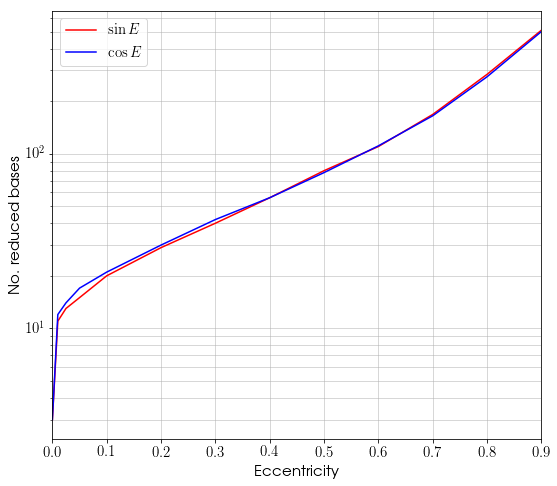

In [6]:
fig, ax = pl.subplots(figsize=(8, 7))
ax.semilogy(eccs, Nbecca[:,0], 'r', label=r'$\sin{E}$')
ax.semilogy(eccs, Nbecca[:,1], 'b', label=r'$\cos{E}$')
ax.grid(True, which='both', lw=0.5)
ax.set_xlim([eccs[0], eccs[-1]])
ax.set_xlabel('Eccentricity')
ax.set_ylabel('No. reduced bases')
ax.legend()

fig.tight_layout()
fig.savefig('ecc_numbases.pdf')

In [7]:
print t

eccentricity No. bases sinU No. bases cosU
------------ -------------- --------------
         0.0              3              3
        0.01             11             12
       0.025             13             14
        0.05             15             17
         0.1             20             21
         0.2             29             30
         0.3             40             42
         0.4             56             56
         0.5             80             78
         0.6            110            111
         0.7            168            165
         0.8            285            276
         0.9            510            501
